In [ ]:
"""
The following notebook was used in the Dendritome MORF project to assign regional probabilities to all of the registered neuron (.swc) files 
under the condition that the neuron lies within a subregion of the Caudateputamen or any adjacent, gray matter anatomical structure.
"""

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib notebook
%matplotlib widget

import sys
sys.path.append('/home/dtward/data/csh_data/emlddmm')
sys.path.append('/home/abenneck/Desktop/emlddmm')
import emlddmm
import csv
from skimage.measure import marching_cubes
from glob import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from os.path import split,join,splitext

import pandas as pd
from scipy.stats import multivariate_normal
import os

from scipy.ndimage import distance_transform_edt
import time

sys.path.append('/home/abenneck')

saveData = False

# 0. Define region IDs and file locations

In [2]:
ontology_name = '/home/abenneck/mounts/bmaproot/nafs/dtward/dong/upenn_atlas/atlas_info_KimRef_FPbasedLabel_v2.7.csv'
seg_name = '/home/abenneck/mounts/bmaproot/nafs/dtward/dong/upenn_atlas/UPenn_labels_reoriented_origin.vtk'

In [3]:
# L0 CP regions
regionID_cp = 672 # Caudate Putamen

# L1 CP regions
regionID_cpr = 2491     # CP, rostral
regionID_cpre = 2376    # CP, rostral extreme
regionID_cpi = 2492     # CP, intermediate
regionID_cpc = 2496     # CP, caudal
regionID_cpce = 2495    # CP, caudal extreme

# L2 CP regions
regionID_cpr_m = 2294   # CPr, medial
regionID_cpr_imd = 2295 # CPr, intermediate dorsal
regionID_cpr_imv = 2296 # CPr, intermediate ventral
regionID_cpr_l = 2497   # CPr, lateral
regionID_cpi_dm = 2498  # CPi, dorsomedial
regionID_cpi_vm = 2500  # CPi, ventromedial
regionID_cpi_dl = 2499  # CPi, dorsolateral
regionID_cpi_vl = 2501  # CPi, ventrolateral
regionID_cpc_d = 2493   # CPc, dorsal
regionID_cpc_i = 2494   # CPc, intermediate
regionID_cpc_v = 2490   # CPc, ventral

# Non-CP gray matter regions
regionID_ast = 2050     # Amygdalostriatal nucleus
regionID_acb = 56       # Accumbens nucleus
regionID_ipac = 998     # Interstitial nucleus of the posterior limb of the anterior commissure
regionID_tu = 754       # Olfactory tubercle
regionID_lsx = 275      # Lateral septal complex
regionID_samy = 278     # Striatum-like amygdalar nuclei
regionID_pal = 803      # Pallidum
regionID_cl = 583       # Claustrum
regionID_en = 942       # Endopiriform nucleus
regionID_pir = 961      # Piriform nucleus

# Non-CP regions
regionID_lv = 81        # Lateral ventricle
regionID_3V = 129       # 3rd ventricle
regionID_Aq = 140       # Aqueduct
regionID_4V = 145       # 4th ventricle
regionID_centCan = 164  # Central canal
regionID_cc = 776       # Corpus callosum

### Load UPenn ontology + Generate lists of descendents

In [4]:
xS,S,_,_ = emlddmm.read_data(seg_name)

In [5]:
# Transforms xS into a set of coordinates
XS = np.stack(np.meshgrid(*xS,indexing='ij'),-1)

In [6]:
# Center of mass of region 2294 (Definition of the 1st moment of the indicator function for label 2294)
# np.sum(XS*(S[0,...,None]==2294))/np.sum(S==2294)

In [7]:
parent_column = 7 # 8 for allen, 7 for yongsoo
label_column = 0 # 0 for both
shortname_column = 2# 3 for allen, 2 for yongsoo
longname_column = 1# 2 for allen, 1 for yongsoo
ontology = dict()
with open(ontology_name) as f:
    csvreader = csv.reader(f, delimiter=',', quotechar='"')
    count = 0
    for row in csvreader:        
        if count == 0:
            headers = row
            print(headers)
        else:
            if not row[parent_column]:
                parent = -1
            else:
                parent = int(row[parent_column])
            ontology[int(row[label_column])] = (row[shortname_column],row[longname_column],parent)
        count += 1


['\ufeffid', 'name', 'acronym', 'red', 'green', 'blue', 'structure_order', 'parent_id', 'parent_acronym']


In [8]:
# we need to find all the descendants of a given label
# first we'll get children
children = dict()
for o in ontology:
    parent = ontology[o][-1]
    if parent not in children:
        children[parent] = []
    children[parent].append(o)

In [9]:
# now we go from children to descendents
descendents = dict(children)
for o in descendents:
    for child in descendents[o]:
        if child in descendents: # if I don't do this i get a key error 0
            descendents[o].extend(descendents[child])
descendents[0] = []

In [10]:
descendents_and_self = dict(descendents)
for o in ontology:
    if o not in descendents_and_self:
        descendents_and_self[o] = [o]
    else:
        descendents_and_self[o].append(o)

## Generate Boolean masks for CP, CPr (+CPre), CPi, CPc (+CPce)

In [11]:
# find all the descendents of Caudoputemen- rostral
# and caudoputemen rostral- extreme

In [12]:
# these are all the structures in the CP
cp = list(descendents_and_self[672])
Scp = np.zeros_like(S)
for l in cp:
    Scp = np.logical_or(Scp,S==l)

In [13]:
# these are the structures one level below CP, with extreme's merged in
rostral = list(descendents_and_self[2376]) # rostral extreme
rostral.extend(list(descendents_and_self[2491])) # rostral 
rostral = list(dict.fromkeys(rostral))

intermediate = list(descendents_and_self[2492]) # intermediate

caudal = list(descendents_and_self[2496]) # caudal
caudal_ = list(descendents_and_self[2495]) # caudal extreme
caudal.extend(caudal_)

In [14]:
Srostral = np.zeros_like(S)
for l in rostral:
    Srostral = np.logical_or(Srostral, S==l)

In [15]:
Sintermediate = np.zeros_like(S)
for l in intermediate:
    Sintermediate = np.logical_or(Sintermediate, S==l)

In [16]:
Scaudal = np.zeros_like(S)
for l in caudal:
    Scaudal = np.logical_or(Scaudal, S==l)

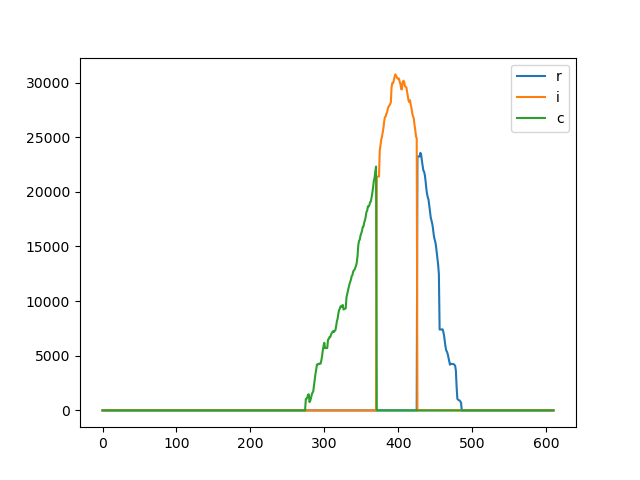

In [17]:
atlas_x, atlas_y, atlas_z = xS

fig,ax = plt.subplots()
ax.plot(np.sum(Srostral>0,axis=(0,2,3)),label='r')
ax.plot(np.sum(Sintermediate>0,axis=(0,2,3)),label='i')
ax.plot(np.sum(Scaudal>0,axis=(0,2,3)),label='c')
# ax.set_xticks(atlas_x, minor=True)
# ax.minorticks_off()
ax.legend()

In [18]:
def generate_region_mask(S, regionID):
    self_and_children = list(descendents_and_self[regionID])
    region_mask = np.zeros_like(S)
    for i in self_and_children:
        region_mask = np.logical_or(region_mask, S==i)
    return region_mask

# === Striatum Dorsal Region (STRd) ===

# CP regions (L2)
Scpr_m   = generate_region_mask(S,2294)
Scpr_imd = generate_region_mask(S,2295)
Scpr_imv = generate_region_mask(S,2296)
Scpr_l   = generate_region_mask(S,2497)
Scpi_dm  = generate_region_mask(S,2498)
Scpi_vm  = generate_region_mask(S,2500)
Scpi_dl  = generate_region_mask(S,2499)
Scpi_vl  = generate_region_mask(S,2501)
Scpc_d   = generate_region_mask(S,2493)
Scpc_i   = generate_region_mask(S,2494)
Scpc_v   = generate_region_mask(S,2490)

# Non-CP regions
# S_lss = generate_region_mask(S,2001) # Lateral strip of the striatum (Outdated)
S_ast = generate_region_mask(S,2050) # Amygdalostriatial transition

# === Striatum Ventral Region (STRv) ===
S_acb  = generate_region_mask(S,56)  # Accumbens nucleus
S_ipac = generate_region_mask(S,998) # Interstitial nucleus of the posterior limb of the anterior commissure
S_tu   = generate_region_mask(S,754) # Olfactory tubercle

# === (10/3/23) Striatum adjacent regions ===
S_lsx = generate_region_mask(S,275)  # Lateral septal complex
S_samy = generate_region_mask(S,278) # Striatum-like amygdalar nuclei
S_pal = generate_region_mask(S,803)  # Pallidum

# === (10/4/23) Striatum adjacent regions ===
S_cl =   generate_region_mask(S,583) # Claustrum
S_en =   generate_region_mask(S,942) # Endopiriform nucleus
S_pir =  generate_region_mask(S,961) # Piriform nucleus

# === (11/6/23) Regions for distance computations ===
S_lv = generate_region_mask(S,regionID_lv)
S_3V = generate_region_mask(S,regionID_3V)
S_Aq = generate_region_mask(S,regionID_Aq)
S_4V = generate_region_mask(S,regionID_4V)
S_centralCanal = generate_region_mask(S,regionID_centCan)

S_cc = generate_region_mask(S,regionID_cc)

S_cp_and_acb = np.logical_or(Scp, S_acb == 1)   # Create mask for all CP and ACB voxels
S_not_cp_or_acb = np.zeros_like(S)
S_not_cp_or_acb[S != 0] = 1                     # Create a copy of S where all nonzero voxels are 1
S_not_cp_or_acb[S_cp_and_acb == 1] = 0          # Set all voxels witin CP or ACB to 0

# 1. Probability Regional Assignments

In [19]:
# so what is a plan going forward
# I'd like to take every blob as a gaussian
# the height is its volume
# the mean is its mean
# the covariance is its covariance
# the only trouble here is the left right issue
# another posiblility is to just blur the labels
# this may get rid of small structures though
# but I could give less blur to the small structures

In [20]:
# first going forward
# 1. make a figure like this to get a sense of the uncertainty for each brain
# 2. make a probabilitistic version of the CP structures.
# I'd like to model each structure as a gaussian blob (ellispoids with soft boundaries)
# this needs three parameters
# the mean (a 3 element vector)
# the covariance (3x3 symmetric matrix)
# and the height/amplitude of the gaussian (one positive number)

# The height (amplitude) should be the number of voxels in the structure
# the mean, is going to be the first moment of the segmentation
# the covariance, is the second central moment of the segmentation.

### Compute + Save Gaussian parameters for CP

In [21]:
def generate_gaussian_param(subregion_mask, hemi, fname):
    if hemi == 'R':
        LR_indicator = (xS[1][:,None]>=0) # Right hemisphere
    else:
        LR_indicator = (xS[1][:,None]<0)  # Left hemisphere
    
    # ===== Compute Gaussian parameters =====
    
    # number of voxels in 'subregion'
    Ncp = np.sum(subregion_mask*LR_indicator)
    
    # let's compute the first moment
    mucp = [np.sum(xS[0][:,None,None]*subregion_mask*LR_indicator)/Ncp, np.sum(xS[1][:,None]*subregion_mask*LR_indicator)/Ncp, np.sum(xS[2][:]*subregion_mask*LR_indicator)/Ncp]
    
    # now calculate the covariance matrix
    covcp01 = np.sum((xS[0][:,None,None] - mucp[0])*(xS[1][:,None] - mucp[1])*subregion_mask*LR_indicator)/Ncp # here row 0 column 1
    covcp02 = np.sum((xS[0][:,None,None] - mucp[0])*(xS[2][None,:] - mucp[2])*subregion_mask*LR_indicator)/Ncp # here row 0 column 2
    covcp12 = np.sum((xS[1][None,:,None] - mucp[1])*(xS[2][None,:] - mucp[2])*subregion_mask*LR_indicator)/Ncp # here row 1 column 2
    
    covcp00 = np.sum(((xS[0][:,None,None] - mucp[0])**2)*subregion_mask*LR_indicator)/Ncp # here row 0 column 0
    covcp11 = np.sum(((xS[1][None,:,None] - mucp[1])**2)*subregion_mask*LR_indicator)/Ncp # here row 1 column 1
    covcp22 = np.sum(((xS[2][None,None,:] - mucp[2])**2)*subregion_mask*LR_indicator)/Ncp # here row 2 column 2
    
    covcp = [[covcp00,covcp01,covcp02],[covcp01,covcp11,covcp12],[covcp02,covcp12,covcp22]]
    
    # Save Gaussian parameters in.npz file with keys [height, mu, cov]
    save_path = join('/home/abenneck/dragonfly_work/gaussian_parameters/',fname)
    np.savez(save_path,height=[Ncp],mu=mucp,cov=covcp)
    print(f'Saved {fname}\n')

genParam = False
if genParam:
    for hemi in ['L','R']:
        generate_gaussian_param(Scp, hemi,f'cp_param_{hemi}.npz')
        generate_gaussian_param(Srostral, hemi,f'cpr_param_{hemi}.npz')
        generate_gaussian_param(Sintermediate, hemi,f'cpi_param_{hemi}.npz')
        generate_gaussian_param(Scaudal, hemi,f'cpc_param_{hemi}.npz')
        
        generate_gaussian_param(Scpr_m, hemi,f'cpr_m_param_{hemi}.npz')
        generate_gaussian_param(Scpr_imd, hemi,f'cpr_imd_param_{hemi}.npz')
        generate_gaussian_param(Scpr_imv, hemi,f'cpr_imv_param_{hemi}.npz')
        generate_gaussian_param(Scpr_l, hemi,f'cpr_l_param_{hemi}.npz')
        
        generate_gaussian_param(Scpi_dm, hemi,f'cpi_dm_param_{hemi}.npz')
        generate_gaussian_param(Scpi_vm, hemi,f'cpi_vm_param_{hemi}.npz')
        generate_gaussian_param(Scpi_dl, hemi,f'cpi_dl_param_{hemi}.npz')
        generate_gaussian_param(Scpi_vl, hemi,f'cpi_vl_param_{hemi}.npz')
        
        generate_gaussian_param(Scpc_d, hemi,f'cpc_d_param_{hemi}.npz')
        generate_gaussian_param(Scpc_i, hemi,f'cpc_i_param_{hemi}.npz')
        generate_gaussian_param(Scpc_v, hemi,f'cpc_v_param_{hemi}.npz')

        generate_gaussian_param(S_ast, hemi, f'ast_param_{hemi}.npz')
        
        generate_gaussian_param(S_acb, hemi, f'acb_param_{hemi}.npz')
        generate_gaussian_param(S_ipac, hemi, f'ipac_param_{hemi}.npz')
        generate_gaussian_param(S_tu, hemi, f'tu_param_{hemi}.npz')
        
        generate_gaussian_param(S_lsx, hemi, f'lsx_param_{hemi}.npz')
        generate_gaussian_param(S_samy, hemi, f'samy_param_{hemi}.npz')
        generate_gaussian_param(S_pal, hemi, f'pal_param_{hemi}.npz')
        
        generate_gaussian_param(S_cl, hemi,f'cl_param_{hemi}.npz')
        generate_gaussian_param(S_en, hemi,f'en_param_{hemi}.npz')
        generate_gaussian_param(S_pir, hemi,f'pir_param_{hemi}.npz')

### Compute distance transform for each mask

In [22]:
def generateDistanceTransform(xS, mask, hemi, fname, save_path = '', scale_factor = 10):
    start = time.time()
    if hemi == 'R':
        LR_indicator = (xS[1][:,None]>=0) # Right hemisphere
    elif hemi == 'L':
        LR_indicator = (xS[1][:,None]<0)  # Left hemisphere
    else:
        LR_indicator = 1.0 # Whole brain

    if save_path == '':
        save_path = '/home/abenneck/dragonfly_work/distance_parameters/'

    transformedMask = distance_transform_edt(1-mask*LR_indicator)
      
    # Save distance transform parameters in .npz file with keys [mask]
    save_path = join(save_path,fname)
    np.savez(save_path, mask = transformedMask.astype(np.float32))
    print(f'Saved {fname} after {time.time() - start : .2f} s')
    
    return transformedMask

saveDistanceParam = False
if saveDistanceParam:
    for hemi in ['L','R']:
        generateDistanceTransform(xS, Scp, hemi, f'cp_dist_param_{hemi}.npz')
        generateDistanceTransform(xS, Srostral, hemi, f'cpr_dist_param_{hemi}.npz')
        generateDistanceTransform(xS, Sintermediate, hemi, f'cpi_dist_param_{hemi}.npz')
        generateDistanceTransform(xS, Scaudal, hemi, f'cpc_dist_param_{hemi}.npz')
    
        generateDistanceTransform(xS, Scpr_m, hemi, f'cpr_m_dist_param_{hemi}.npz')
        generateDistanceTransform(xS, Scpr_imd, hemi, f'cpr_imd_dist_param_{hemi}.npz')
        generateDistanceTransform(xS, Scpr_imv, hemi, f'cpr_imv_dist_param_{hemi}.npz')
        generateDistanceTransform(xS, Scpr_l, hemi, f'cpr_l_dist_param_{hemi}.npz')
    
        generateDistanceTransform(xS, Scpi_dm, hemi, f'cpi_dm_dist_param_{hemi}.npz')
        generateDistanceTransform(xS, Scpi_vm, hemi, f'cpi_vm_dist_param_{hemi}.npz')
        generateDistanceTransform(xS, Scpi_dl, hemi, f'cpi_dl_dist_param_{hemi}.npz')
        generateDistanceTransform(xS, Scpi_vl, hemi, f'cpi_vl_dist_param_{hemi}.npz')
    
        generateDistanceTransform(xS, Scpc_d, hemi, f'cpc_d_dist_param_{hemi}.npz')
        generateDistanceTransform(xS, Scpc_i, hemi, f'cpc_i_dist_param_{hemi}.npz')
        generateDistanceTransform(xS, Scpc_v, hemi, f'cpc_v_dist_param_{hemi}.npz')

        generateDistanceTransform(xS, S_ast, hemi, f'ast_dist_param_{hemi}.npz')
        
        generateDistanceTransform(xS, S_acb, hemi, f'acb_dist_param_{hemi}.npz')
        generateDistanceTransform(xS, S_ipac, hemi, f'ipac_dist_param_{hemi}.npz')
        generateDistanceTransform(xS, S_tu, hemi, f'tu_dist_param_{hemi}.npz')
        
        generateDistanceTransform(xS, S_lsx, hemi, f'lsx_dist_param_{hemi}.npz')
        generateDistanceTransform(xS, S_samy, hemi, f'samy_dist_param_{hemi}.npz')
        generateDistanceTransform(xS, S_pal, hemi, f'pal_dist_param_{hemi}.npz')

        generateDistanceTransform(xS, S_cl, hemi, f'cl_dist_param_{hemi}.npz')
        generateDistanceTransform(xS, S_en, hemi, f'en_dist_param_{hemi}.npz')
        generateDistanceTransform(xS, S_pir, hemi, f'pir_dist_param_{hemi}.npz')

        generateDistanceTransform(xS, S_lv, hemi, f'lv_dist_param_{hemi}.npz')
        generateDistanceTransform(xS, S_3V, hemi, f'3V_dist_param_{hemi}.npz')
        generateDistanceTransform(xS, S_Aq, hemi, f'Aq_dist_param_{hemi}.npz')
        generateDistanceTransform(xS, S_4V, hemi, f'4V_dist_param_{hemi}.npz')
        generateDistanceTransform(xS, S_centralCanal, hemi, f'centralCanal_dist_param_{hemi}.npz')
        generateDistanceTransform(xS, S_cc, hemi, f'cc_dist_param_{hemi}.npz')

    generateDistanceTransform(xS, S_cp_and_acb, 'w', f'cp_acb_dist_param.npz')
    generateDistanceTransform(xS, S_not_cp_or_acb, 'w', f'not_cp_acb_dist_param.npz')

### Preprocessing helper functions

In [23]:
# Filter which returns true for all distance transforms for L1 CP structures
def L1_filter_dist(fileName):
    if len(fileName) <= 21 and fileName != '.ipynb_checkpoints' and 'cp' in fileName and wm_vent_filter(fileName) and multi_filter(fileName):
        return True
    else:
        return False

# Filter which returns true for all distance transforms for L2 CP structures
def L2_filter_dist(fileName):
    if len(fileName) > 21 and fileName != '.ipynb_checkpoints' and 'cp' in fileName and wm_vent_filter(fileName) and multi_filter(fileName):
        return True
    else:
        return False
        
# Filter which returns true for all distance transforms for all non-CP gray matter structures
def non_CP_filter_dist(fileName):
    if not L2_filter_dist(fileName) and not L1_filter_dist(fileName) and fileName != '.ipynb_checkpoints' and wm_vent_filter(fileName) and multi_filter(fileName):
        return True
    else:
        return False

# Filter which returns true for all distance transforms that are NOT white matter or ventricle structures
def wm_vent_filter(fileName):
    fnames_to_ignore = ['lv_dist_param_L.npz','ivf_dist_param_L.npz', '3V_dist_param_L.npz', 'Aq_dist_param_L.npz', '4V_dist_param_L.npz', 'centralCanal_dist_param_L.npz', 'cc_dist_param_L.npz', 'lv_dist_param_R.npz', 'ivf_dist_param_R.npz', '3V_dist_param_R.npz', 'Aq_dist_param_R.npz', '4V_dist_param_R.npz', 'centralCanal_dist_param_R.npz', 'cc_dist_param_R.npz']
    for fname in fnames_to_ignore:
        if fname == fileName:
            return False
    return True

# Filter to skip cp_acb and not_cp_acb
def multi_filter(fileName):
    fnames_to_ignore = ['cp_acb_dist_param.npz','not_cp_acb_dist_param.npz']
    for fname in fnames_to_ignore:
        if fname == fileName:
            return False
    return True


# Returns list of (x,y,z) coordinates for 'region_id' and any child subregions
def get_coord_list(region_id, XS, S):
    self_and_children = list(descendents_and_self[region_id])
    allCoords = list()
    for idNum in self_and_children:
        regionCoords = XS[S[0]==idNum]
        if len(regionCoords) != 0:
            for coord in regionCoords:
                allCoords.append(coord)
    return allCoords

### Probability computation helper functions

In [24]:
# Computes minimum Euclidean distance between 'soma_location' ([x, y, z]) and 'regionCoords' (n * [x, y, z])
def dist_from_region(regionCoords, soma_location):
    # out = allCoords-soma_location => [allCoords[0]-soma_location, allCoords[1]-soma_location, ...]
    # out = (out)**2                => Square all terms within out
    # out = np.sum(out, axis=1)     => [out[0][0]+out[0][1]+out[0][2], out[1][0]+out[1][1]+out[1][2], ...]
    # out = np.sqrt(out)            => sqrt all terms within out
    # out = np.min(out)             => min of all distances
    return np.min(np.sqrt(np.sum((regionCoords-soma_location)**2, axis=1)))

# Round neuron coord to nearest atlas coord
def roundCoord(sub_xS, coord, type = '20um'):
    if coord < np.min(sub_xS):
        coord = np.min(sub_xS)
    elif coord > np.max(sub_xS):
        coord = np.max(sub_xS)
    elif type == '50um':
        coord_rounded = 50*round(coord/50) # Round coordinate to nearest 50
        if coord < 0:
            if coord - coord_rounded >= 0:
                coord = coord_rounded + 25
            else:
                coord = coord_rounded - 25
        else:
            if coord - coord_rounded >= 0:
                coord = coord_rounded + 25
            else:
                coord = coord_rounded - 25
    else:
        coord_rounded = 20*round(coord/20) # Round coordinate to nearest 20
        if coord < 0:
            if coord - coord_rounded >= 0:
                coord = coord_rounded + 10
            else:
                coord = coord_rounded - 10
        else:
            if coord - coord_rounded >= 0:
                coord = coord_rounded + 10
            else:
                coord = coord_rounded - 10
    return coord

# HELPER FUNCTION: Appends all nonCP regions used for conditional probabilites
def append_nonCP_regions(allProb):
    nonCP_regions = ['ACB','AST','CL','EN','LSX','PAL','PIR','SAMY']
    for l in range(3):
        if l == 0:
            last_CP_col = 'CP_R'
        elif l == 1:
            last_CP_col = 'CPr_R'
        else: # l == 2
            last_CP_col = 'CPr_m_R'

        for i,region in enumerate(nonCP_regions):
            if i == 0:
                prevCol = last_CP_col
            else:
                prevCol = f'{nonCP_regions[i-1]}{l}_R'

            allProb.insert(allProb.columns.get_loc(prevCol)+1,f'{region}{l}_L',allProb[f'{region}_L'])
            allProb.insert(allProb.columns.get_loc(f'{region}{l}_L')+1,f'{region}{l}_R',allProb[f'{region}_R'])
    return allProb    

# Absolute probabilities => (Normalize probabilities at multiple levels) => Conditional probabilities
def normalize_prob(allProb):    
    L0_labels = ['CP_L','CP_R','ACB0_L','ACB0_R','AST0_L','AST0_R','CL0_L','CL0_R','EN0_L','EN0_R','LSX0_L','LSX0_R','PAL0_L','PAL0_R','PIR0_L','PIR0_R','SAMY0_L','SAMY0_R']
    allProb[L0_labels] = allProb[L0_labels].div(np.sum(allProb[L0_labels], axis=1), axis=0)

    L1_labels = ['CPc_L','CPc_R','CPi_L','CPi_R','CPr_L','CPr_R','ACB1_L','ACB1_R','AST1_L','AST1_R','CL1_L','CL1_R','EN1_L','EN1_R','LSX1_L','LSX1_R','PAL1_L','PAL1_R','PIR1_L','PIR1_R','SAMY1_L','SAMY1_R']
    allProb[L1_labels] = allProb[L1_labels].div(np.sum(allProb[L1_labels], axis=1), axis=0)
    
    L2_labels = ['CPc_d_L','CPc_d_R','CPc_i_L','CPc_i_R','CPc_v_L','CPc_v_R','CPi_dl_L','CPi_dl_R','CPi_dm_L','CPi_dm_R','CPi_vl_L','CPi_vl_R','CPi_vm_L','CPi_vm_R','CPr_imd_L','CPr_imd_R','CPr_imv_L','CPr_imv_R','CPr_l_L','CPr_l_R','CPr_m_L','CPr_m_R','ACB2_L','ACB2_R','AST2_L','AST2_R','CL2_L','CL2_R','EN2_L','EN2_R','LSX2_L','LSX2_R','PAL2_L','PAL2_R','PIR2_L','PIR2_R','SAMY2_L','SAMY2_R']
    allProb[L2_labels] = allProb[L2_labels].div(np.sum(allProb[L2_labels], axis=1), axis=0)

    nonCP_labels = ['ACB_L','ACB_R','AST_L','AST_R','CL_L','CL_R','EN_L','EN_R','LSX_L','LSX_R','PAL_L','PAL_R','PIR_L','PIR_R','SAMY_L','SAMY_R']
    allProb[nonCP_labels] = allProb[nonCP_labels].div(np.sum(allProb[nonCP_labels], axis=1), axis=0)

    multi_labels = ['CP_ACB', 'not_CP_ACB']
    allProb[multi_labels] = allProb[multi_labels].div(np.sum(allProb[multi_labels], axis=1), axis=0)

    return allProb

# Convert distance transforms into probability distributions
def dist_transform_to_prob_dist(dist, scale_factor = 10):
    transformedMask = np.exp(-dist/scale_factor)
    transformedMask = transformedMask / np.sum(transformedMask)
    return transformedMask

### Postprocessing helper functions

In [25]:
# Filter to remove the .ipynb_checkpoints file from lists
def brain_filter(dirName):
    if dirName == '.ipynb_checkpoints' or dirName == 'TME20-1':
        return False
    else:
        return True

# Return a pd.DataFrame (1 x len (df)) of the column name in df containing the corresponding value in vals for each row of df
def xlookup(vals, df, cName = ''):
    out = list()
    for row in df.iterrows():
        idx, row = row
        val = vals[idx]
        colName = row[row == val].keys()[0]
        out.append(colName)
    return pd.DataFrame(data=out, columns = [cName])

# Return a pd.Series (1 x len(df)) of the nth largest value in each row of df
def nmax(df, n):
    out = list()
    for row in df.iterrows():
        idx, row = row
        nth_largest = sorted(row, reverse=True)[n-1]
        out.append(nth_largest)
    return pd.Series(data=out)

# Appends columns containing the top 3 most probable regions + the associated probabilities to the data df
def compute_top_n_maximums(data, all_labels, n=3):
    
    for i, labels in enumerate(all_labels):
        L0_df = data[labels]
        
        L0_P1 = L0_df.max(axis=1)
        L0_1 = xlookup(L0_P1, L0_df)
    
        if i == 0:
            leftmost_col_name = 'fname'
        else:
            leftmost_col_name = f'P(L{i-1},3)'
        
        data.insert(data.columns.get_loc(leftmost_col_name)+1,f'L{i} (1)',L0_1)
        data.insert(data.columns.get_loc(f'L{i} (1)')+1,f'P(L{i},1)',L0_P1)
        
        L0_P2 = nmax(L0_df, 2)
        L0_2 = xlookup(L0_P2, L0_df)
        data.insert(data.columns.get_loc(f'P(L{i},1)')+1,f'L{i} (2)',L0_2)
        data.insert(data.columns.get_loc(f'L{i} (2)')+1,f'P(L{i},2)',L0_P2)
        
        L0_P3 = nmax(L0_df,3)
        L0_3 = xlookup(L0_P3, L0_df)
        data.insert(data.columns.get_loc(f'P(L{i},2)')+1,f'L{i} (3)',L0_3)
        data.insert(data.columns.get_loc(f'L{i} (3)')+1,f'P(L{i},3)',L0_P3)

    return data

## Generate probability distributions, assign labels to neurons, and save csv files locally

In [30]:
brains = ['TME07-1', 'TME08-1', 'TME09-1', 'TME10-1', 'TME10-3', 'hTME15-1', 'hTME15-2', 'hTME18-1', 'hTME19-2', 'hTME16-1','hTME20-1','hTME24-2']

# Create list of all coordinates within the CP
allRegionCoords = get_coord_list(672, XS, S) # 672 is regionID for CP
allRegionCoords = np.asarray(allRegionCoords)

print('Loading distance transform distributions')
start = time.time()

# Create list of distributions from presaved distance transforms
paramDir = '/home/abenneck/mounts/bmaproot/nafs/dtward/andrew_work/test/dragonfly_work/distance_parameters'
L1_files = sorted(filter(L1_filter_dist,os.listdir(paramDir)))
L2_files = sorted(filter(L2_filter_dist,os.listdir(paramDir)))
nonCP_files = sorted(filter(non_CP_filter_dist,os.listdir(paramDir)))
multi_files = ['cp_acb_dist_param.npz','not_cp_acb_dist_param.npz']

scale_factor = 5
allTransforms = list()
for fileList in [L1_files, L2_files, nonCP_files, multi_files]:
    for file in fileList:
        data = np.load(os.path.join(paramDir,file))
        distTrans = data['mask']
        probDist = dist_transform_to_prob_dist(distTrans, scale_factor = scale_factor)
        allTransforms.append(probDist)
        print(file)
print(f'Finished loading distributions in {time.time() - start} s\n')

# Generate probabilities
uniform_prior = 1/100
print('Generating probabilities')
start = time.time()
for brain in brains:
    # Define relevant directories
    if 'hTME' in brain and brain not in ['hTME16-1','hTME20-1','hTME24-2']:
        neuronDir = f'/home/abenneck/mounts/bmaproot/nafs/dtward/andrew_work/test/dragonfly_work/dragonfly_outputs_weighted/{brain}/dragonfly_joint_outputs/'
    elif brain in ['hTME16-1','hTME20-1','hTME24-2']:
        neuronDir = f'/home/abenneck/mounts/bmaproot/nafs/dtward/andrew_work/test/dragonfly_work/dragonfly_outputs_new_hTME/{brain}/step3_out/'
    else:
        neuronDir = f'/home/abenneck/mounts/bmaproot/nafs/dtward/andrew_work/test/dragonfly_work/dragonfly_outputs/{brain}/dragonfly_joint_outputs/'

    # Note: The ACB#_x columns are inserted after computing absolute probabilities, but before normalization
    L0_col = ['mouse ID', 'slice', 'hemi', 'neuron ID','fname','CP_L','CP_R']
    L1_col = ['CPc_L','CPc_R','CPi_L','CPi_R','CPr_L','CPr_R',]
    L2_col = ['CPc_d_L','CPc_d_R','CPc_i_L','CPc_i_R','CPc_v_L','CPc_v_R','CPi_dl_L','CPi_dl_R','CPi_dm_L','CPi_dm_R','CPi_vl_L','CPi_vl_R','CPi_vm_L','CPi_vm_R','CPr_imd_L','CPr_imd_R','CPr_imv_L','CPr_imv_R','CPr_l_L','CPr_l_R','CPr_m_L','CPr_m_R']
    nonCP_col = ['ACB_L','ACB_R','AST_L','AST_R','CL_L','CL_R','EN_L','EN_R','LSX_L','LSX_R','PAL_L','PAL_R','PIR_L','PIR_R','SAMY_L','SAMY_R']
    multi_col = ['CP_ACB', 'not_CP_ACB']
    allCol = np.concatenate([L0_col, L1_col, L2_col, nonCP_col, multi_col])
    allProb = pd.DataFrame(columns=allCol)
    
    # Generate regional probabilities for every neuron in neuronDir
    row_idx = 0
    for i, file in enumerate(sorted(os.listdir(neuronDir))):
        if "mapped.swc" in file and 'checkpoint' not in file:
            # Load soma coordinates
            data = pd.read_csv(os.path.join(neuronDir,file))
            x = float(data.columns[2])
            y = float(data.columns[3])
            z = float(data.columns[4])
            soma_location = [x,y,z]

            # Get idx for soma location in xS
            x_ind = np.where(xS[0] == roundCoord(xS[0], x))[0].item()
            y_ind = np.where(xS[1] == roundCoord(xS[1], y))[0].item() 
            z_ind = np.where(xS[2] == roundCoord(xS[2], z))[0].item()

            if 'hTME' in brain:
                mouseID = file.split('_')[0]
                hemiID = 'N/A'
                neuronID = 'N/A'
                if brain in ['hTME16-1', 'hTME20-1', 'hTME24-2']:
                    sliceID = file.split('_')[1]
                else:
                    sliceID = file.split('_')[2]
            else:
                # Get metadata from filename
                mouseID = file.split('_')[1]
                sliceID = file.split('_')[4][:-1]
                hemiID = file.split('_')[4][-1]
                neuronID = int(file.split('_')[0])
    
            # Compute probabilities from distance transform probabilities
            neuronProb = [mouseID, sliceID, hemiID, neuronID, file]
            for transform in allTransforms:
                neuronProb.append(uniform_prior*transform[0, x_ind, y_ind, z_ind])

            allProb.loc[row_idx] = neuronProb
            row_idx+=1

    # Insert Non-CP regions at each level
    allProb = append_nonCP_regions(allProb)

    # Normalize probabilities at each level
    allProb = normalize_prob(allProb)

    # Identify top 3 regions for each neuron and insert columns into allProb
    L0_labels = ['CP_L','CP_R','ACB0_L','ACB0_R','AST0_L','AST0_R','CL0_L','CL0_R','EN0_L','EN0_R','LSX0_L','LSX0_R','PAL0_L','PAL0_R','PIR0_L','PIR0_R','SAMY0_L','SAMY0_R']
    L1_labels = ['CPc_L','CPc_R','CPi_L','CPi_R','CPr_L','CPr_R','ACB1_L','ACB1_R','AST1_L','AST1_R','CL1_L','CL1_R','EN1_L','EN1_R','LSX1_L','LSX1_R','PAL1_L','PAL1_R','PIR1_L','PIR1_R','SAMY1_L','SAMY1_R']
    L2_labels = ['CPc_d_L','CPc_d_R','CPc_i_L','CPc_i_R','CPc_v_L','CPc_v_R','CPi_dl_L','CPi_dl_R','CPi_dm_L','CPi_dm_R','CPi_vl_L','CPi_vl_R','CPi_vm_L','CPi_vm_R','CPr_imd_L','CPr_imd_R','CPr_imv_L','CPr_imv_R','CPr_l_L','CPr_l_R','CPr_m_L','CPr_m_R','ACB2_L','ACB2_R','AST2_L','AST2_R','CL2_L','CL2_R','EN2_L','EN2_R','LSX2_L','LSX2_R','PAL2_L','PAL2_R','PIR2_L','PIR2_R','SAMY2_L','SAMY2_R']
    multi_labels = ['CP_ACB', 'not_CP_ACB'] # No normalization, so omit from all_labels
    all_labels = [L0_labels, L1_labels, L2_labels]

    # Appends columns containing top 3 regions (+ associated probability) with highest probability at L0, L1, and L2 for each neuron
    allProb = compute_top_n_maximums(allProb, all_labels)
    
    # Save probability distributions as one .csv file in tempDir
    tempDir = f'/home/abenneck/dragonfly_work/dragonfly_outputs_new_hTME/post_processing/{brain}_neuron_region_prob_sf{scale_factor}.csv'
    if saveData:
        allProb.to_csv(tempDir, index=False)

    print(f'Finished registering all neurons in {brain} in {time.time() - start:.2f} s with an average of {(time.time() - start) / len(allProb):.2f} s / neuron\n')

Loading distance transform distributions
cp_dist_param_L.npz
cp_dist_param_R.npz
cpc_dist_param_L.npz
cpc_dist_param_R.npz
cpi_dist_param_L.npz
cpi_dist_param_R.npz
cpr_dist_param_L.npz
cpr_dist_param_R.npz
cpc_d_dist_param_L.npz
cpc_d_dist_param_R.npz
cpc_i_dist_param_L.npz
cpc_i_dist_param_R.npz
cpc_v_dist_param_L.npz
cpc_v_dist_param_R.npz
cpi_dl_dist_param_L.npz
cpi_dl_dist_param_R.npz
cpi_dm_dist_param_L.npz
cpi_dm_dist_param_R.npz
cpi_vl_dist_param_L.npz
cpi_vl_dist_param_R.npz
cpi_vm_dist_param_L.npz
cpi_vm_dist_param_R.npz
cpr_imd_dist_param_L.npz
cpr_imd_dist_param_R.npz
cpr_imv_dist_param_L.npz
cpr_imv_dist_param_R.npz
cpr_l_dist_param_L.npz
cpr_l_dist_param_R.npz
cpr_m_dist_param_L.npz
cpr_m_dist_param_R.npz
acb_dist_param_L.npz
acb_dist_param_R.npz
ast_dist_param_L.npz
ast_dist_param_R.npz
cl_dist_param_L.npz
cl_dist_param_R.npz
en_dist_param_L.npz
en_dist_param_R.npz
lsx_dist_param_L.npz
lsx_dist_param_R.npz
pal_dist_param_L.npz
pal_dist_param_R.npz
pir_dist_param_L.npz
pi

/tmp/ipykernel_335903/164679973.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  allProb.insert(allProb.columns.get_loc(f'{region}{l}_L')+1,f'{region}{l}_R',allProb[f'{region}_R'])
/tmp/ipykernel_335903/1276475511.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.insert(data.columns.get_loc(leftmost_col_name)+1,f'L{i} (1)',L0_1)
/tmp/ipykernel_335903/1276475511.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Cons

Finished registering all neurons in TME07-1 in 12.55 s with an average of 0.01 s / neuron



/tmp/ipykernel_335903/164679973.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  allProb.insert(allProb.columns.get_loc(f'{region}{l}_L')+1,f'{region}{l}_R',allProb[f'{region}_R'])
/tmp/ipykernel_335903/1276475511.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.insert(data.columns.get_loc(leftmost_col_name)+1,f'L{i} (1)',L0_1)
/tmp/ipykernel_335903/1276475511.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Cons

Finished registering all neurons in TME08-1 in 15.78 s with an average of 0.08 s / neuron



/tmp/ipykernel_335903/164679973.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  allProb.insert(allProb.columns.get_loc(f'{region}{l}_L')+1,f'{region}{l}_R',allProb[f'{region}_R'])
/tmp/ipykernel_335903/1276475511.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.insert(data.columns.get_loc(leftmost_col_name)+1,f'L{i} (1)',L0_1)
/tmp/ipykernel_335903/1276475511.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Cons

Finished registering all neurons in TME09-1 in 17.55 s with an average of 0.16 s / neuron



/tmp/ipykernel_335903/164679973.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  allProb.insert(allProb.columns.get_loc(f'{region}{l}_L')+1,f'{region}{l}_R',allProb[f'{region}_R'])
/tmp/ipykernel_335903/1276475511.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.insert(data.columns.get_loc(leftmost_col_name)+1,f'L{i} (1)',L0_1)
/tmp/ipykernel_335903/1276475511.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Cons

Finished registering all neurons in TME10-1 in 23.76 s with an average of 0.06 s / neuron



/tmp/ipykernel_335903/164679973.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  allProb.insert(allProb.columns.get_loc(f'{region}{l}_L')+1,f'{region}{l}_R',allProb[f'{region}_R'])
/tmp/ipykernel_335903/1276475511.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.insert(data.columns.get_loc(leftmost_col_name)+1,f'L{i} (1)',L0_1)
/tmp/ipykernel_335903/1276475511.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Cons

Finished registering all neurons in TME10-3 in 37.70 s with an average of 0.04 s / neuron



/tmp/ipykernel_335903/164679973.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  allProb.insert(allProb.columns.get_loc(f'{region}{l}_L')+1,f'{region}{l}_R',allProb[f'{region}_R'])
/tmp/ipykernel_335903/1276475511.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.insert(data.columns.get_loc(leftmost_col_name)+1,f'L{i} (1)',L0_1)
/tmp/ipykernel_335903/1276475511.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Cons

Finished registering all neurons in hTME15-1 in 40.88 s with an average of 0.18 s / neuron



/tmp/ipykernel_335903/164679973.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  allProb.insert(allProb.columns.get_loc(f'{region}{l}_L')+1,f'{region}{l}_R',allProb[f'{region}_R'])
/tmp/ipykernel_335903/1276475511.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.insert(data.columns.get_loc(leftmost_col_name)+1,f'L{i} (1)',L0_1)
/tmp/ipykernel_335903/1276475511.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Cons

Finished registering all neurons in hTME15-2 in 44.91 s with an average of 0.15 s / neuron



/tmp/ipykernel_335903/164679973.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  allProb.insert(allProb.columns.get_loc(f'{region}{l}_L')+1,f'{region}{l}_R',allProb[f'{region}_R'])
/tmp/ipykernel_335903/1276475511.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.insert(data.columns.get_loc(leftmost_col_name)+1,f'L{i} (1)',L0_1)
/tmp/ipykernel_335903/1276475511.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Cons

Finished registering all neurons in hTME18-1 in 48.64 s with an average of 0.17 s / neuron



/tmp/ipykernel_335903/164679973.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  allProb.insert(allProb.columns.get_loc(f'{region}{l}_L')+1,f'{region}{l}_R',allProb[f'{region}_R'])
/tmp/ipykernel_335903/1276475511.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.insert(data.columns.get_loc(leftmost_col_name)+1,f'L{i} (1)',L0_1)
/tmp/ipykernel_335903/1276475511.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Cons

Finished registering all neurons in hTME19-2 in 51.57 s with an average of 0.24 s / neuron



/tmp/ipykernel_335903/164679973.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  allProb.insert(allProb.columns.get_loc(f'{region}{l}_L')+1,f'{region}{l}_R',allProb[f'{region}_R'])
/tmp/ipykernel_335903/1276475511.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.insert(data.columns.get_loc(leftmost_col_name)+1,f'L{i} (1)',L0_1)
/tmp/ipykernel_335903/1276475511.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Cons

Finished registering all neurons in hTME16-1 in 52.98 s with an average of 0.52 s / neuron



/tmp/ipykernel_335903/164679973.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  allProb.insert(allProb.columns.get_loc(f'{region}{l}_L')+1,f'{region}{l}_R',allProb[f'{region}_R'])
/tmp/ipykernel_335903/1276475511.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.insert(data.columns.get_loc(leftmost_col_name)+1,f'L{i} (1)',L0_1)
/tmp/ipykernel_335903/1276475511.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Cons

Finished registering all neurons in hTME20-1 in 54.46 s with an average of 0.54 s / neuron

Finished registering all neurons in hTME24-2 in 55.28 s with an average of 0.91 s / neuron



/tmp/ipykernel_335903/164679973.py:60: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  allProb.insert(allProb.columns.get_loc(f'{region}{l}_L')+1,f'{region}{l}_R',allProb[f'{region}_R'])
/tmp/ipykernel_335903/1276475511.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data.insert(data.columns.get_loc(leftmost_col_name)+1,f'L{i} (1)',L0_1)
/tmp/ipykernel_335903/1276475511.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Cons

# 2. Merge csv files with (position, probability, morphometric features) data

## Merge probability csv files from all brains into one csv

In [ ]:
scale_factor = 5
brains = ['TME07-1', 'TME08-1', 'TME09-1', 'TME10-1', 'TME10-3', 'hTME15-1', 'hTME15-2', 'hTME18-1', 'hTME19-2']
brains = ['hTME16-1', 'hTME20-1', 'hTME24-2']

all_df = list()
for brain in brains:
    if 'hTME16-1' in brains:
        fname = f'/home/abenneck/dragonfly_work/dragonfly_outputs_new_hTME/post_processing/{brain}_neuron_region_prob_sf{scale_factor}.csv'
    else:
        fname = f'/home/abenneck/dragonfly_work/dragonfly_outputs_weighted/post_processing/{brain}_neuron_region_prob_sf{scale_factor}.csv'
    # fname = f'/home/abenneck/dragonfly_work/dragonfly_outputs_weighted/post_processing_50/{brain}_neuron_region_prob_sf{scale_factor}.csv'
    # fname = f'/home/abenneck/dragonfly_work/prob_dist_out/{brain}_neuron_region_prob_sf{scale_factor}.csv'
    data = pd.read_csv(fname)
    all_df.append(data)

main_data = pd.concat(all_df)
if saveData:
    if 'hTME16-1' in brains:
        main_data.to_csv(f'/home/abenneck/dragonfly_work/dragonfly_outputs_new_hTME/post_processing/all_prob_new_hTME.csv', index = False)
    else:
        main_data.to_csv(f'/home/abenneck/dragonfly_work/dragonfly_outputs_weighted/post_processing/neuron_region_prob_sf{scale_factor}_final.csv', index = False)
np.unique(main_data['mouse ID'])

## Generate + save csv containing neuron soma locations, key_name, and slice info

In [ ]:
def get_soma_from_fname(fname, brain):
    '''
    load an swc file => soma location derived from fname
    
    Parameters
    ----------
    fname : str
        A string pointing to the file to load
    skip : int
        Number of lines to skip at the beginning. (default 0)
    
    Returns
    -------
    xyzoff : Array of ints
        the x, y, z offsets between fname and first line
    
    '''
    if 'hTME' in brain or brain in ['Hpca5-2', 'Sp9-3-2', 'Trank1-2-3', 'Zswim4-1', 'MQC06-2', 'MQC09-3', 'MQC18-3', 'MQC82-2']:
        if 'Unmapped' in fname: # neuron_dir is a global variable defined in one of the first cells
            print(fname)
            _, fx, fy, fz = ((fname.split('/'))[-1].split('_')[-1]).split('-')
            fz = fz[:-4]
        else:
            print(fname)
            _, fx, fy, fz = fname.split('_')[3].split('-')
        
        fx, fy, fz = float(fx), float(fy), float(fz)
    elif brain == 'TME10-3':
        fx, fy, fz = fname.split('_')[5:-1]
        fx, fy, fz = fx[1:], fy[1:], fz[1:]
    elif 'TME' in brain:
        fx, fy, fz = fname.split('_')[5:-2]
        fx, fy, fz = fx[1:], fy[1:], fz[1:]
    else:
        raise Exception(f'Invalid brain ({brain}) supplied when calling get_soma_from_fname()')

    return np.array([int(fx), int(fy), int(fz)])

def get_soma_from_first_line(fname, brain):
    ''' load an swc file.
    
    Parameters
    ----------
    fname : str
        A string pointing to the file to load

    Returns
    -------
    V : numpy array of float
        An array storing vertices
    E : numpy array of int
        An array storing edges.  they are ordered as parent -> this sample
    R : numpy array of float
        An arrow storing radii
    
    '''       

    with open(fname,'rt') as f:
        for i,line in enumerate(f):
            # print(f'{i}: {line}')
            if line[0] == '#':
                continue
                
            # print(line)
            data = line.split()
            # may be comma separated
            if len(data)==1:
                data = line.split(',')
            sample_number = int(data[0])
            x = float(data[2])
            y = float(data[3])
            z = float(data[4])
            break
    return x, y, z

In [ ]:
saveAllPos = False

brains = ['TME07-1', 'TME08-1', 'TME09-1', 'TME10-1', 'TME10-3', 'hTME15-1', 'hTME15-2', 'hTME18-1', 'hTME19-2', 'hTME16-1', 'hTME20-1', 'hTME24-2']

allCol = ['fname','key_name','x','y','z','slice','hemi']
df_out = pd.DataFrame(columns=allCol)

row_idx = 0

start = time.time()
for brain in brains:
    
    # Define relevant input directory
    if 'hTME16-1' in brains:
        neuronDir = f'/home/abenneck/nafs/dtward/andrew_work/test/dragonfly_work/dragonfly_outputs_new_hTME/{brain}/step3_out/'
    else:
        neuronDir = f'/home/abenneck/nafs/dtward/andrew_work/test/dragonfly_work/dragonfly_outputs_weighted/{brain}/dragonfly_joint_outputs/'
    # neuronDir = f'/home/abenneck/nafs/dtward/andrew_work/test/dragonfly_work/dragonfly_outputs/{brain}/dragonfly_joint_outputs/'

    for i, file in enumerate(sorted(os.listdir(neuronDir))):
        if "mapped.swc" in file and 'checkpoint' not in file:
            # Load soma coordinates
            data = pd.read_csv(os.path.join(neuronDir,file))
            # x, y, z = get_soma_from_fname(file, brain)
            x, y, z = get_soma_from_first_line(os.path.join(neuronDir,file), brain)

            # Get metadata from filename and initialize row
            if brain in ['hTME16-1', 'hTME20-1', 'hTME24-2']:
                sliceID = file.split('_')[1]
                hemiID = 'N/A'
            elif 'hTME' in brain:
                sliceID = file.split('_')[2]
                hemiID = 'N/A'
            else: # TME brains
                sliceID = file.split('_')[4][:-1]
                hemiID = file.split('_')[4][-1]

            # Generate key from 'file' based on pattern in Ming's csv
            if 'hTME' in brain:
                strOut = file[:-22]
            else:
                strSplits = file.split('_')
                strOut = f'{strSplits[0]}_{strSplits[1]}_{strSplits[2]}_{strSplits[3]}_{strSplits[4]}_xyz-{strSplits[5][1:]}-{strSplits[6][1:]}-{strSplits[7][1:]}'
            # print(strOut)
            
            # row = [file, strOut, x, y, z, sliceID, hemiID, dist_cp, dist_lv, dist_3V, dist_Aq, dist_4V, dist_centCan, dist_cc, dist_brain_bound]
            row = [file, strOut, x, y, z, sliceID, hemiID]
            df_out.loc[row_idx] = row
            row_idx+=1

    print(f'Finished {brain} in {time.time() - start} s\n')

if 'hTME16-1' in brains:
    tempDir = '/home/abenneck/dragonfly_work/dragonfly_outputs_new_hTME/post_processing/all_pos_new_hTME.csv'
else:
    tempDir = f'/home/abenneck/dragonfly_work/dragonfly_outputs_weighted/post_processing/all_pos.csv'

if saveAllPos:
    df_out.to_csv(tempDir, index=False)

## Load 3 morphometric feature csv files + combine into one

In [ ]:
import pandas as pd

# TME_morpho_path = f'/home/abenneck/dragonfly_work/morpho_data/d1d2_subclusters_Dec-14-2023_share.csv'
# TME_morpho_path = f'/home/abenneck/dragonfly_work/morpho_data/D1_D2_morphometrics_Mar-15-2024.csv'
# hTME_HD_morpho_path = f'/home/abenneck/dragonfly_work/morpho_data/d1d2_with_clusters_2hTME_HD_results.by.Brain.Adjusted-Dec-21-2023.csv'
# hTME_WT_morpho_path = f'/home/abenneck/dragonfly_work/morpho_data/d1d2_with_clusters_2hTME_WT_results.by.Brain.Adjusted-Dec-21-2023.csv'

# TME_morpho = pd.read_csv(TME_morpho_path)
# hTME_HD_morpho = pd.read_csv(hTME_HD_morpho_path)
# hTME_WT_morpho = pd.read_csv(hTME_WT_morpho_path)

# TME_fnames_path = f'/home/abenneck/dragonfly_work/morpho_data/D1D2_full_neuron_list_Mar-25-2024.csv'
# TME_fnames = pd.read_csv(TME_fnames_path)

# TME_morpho = TME_morpho.merge(TME_fnames, how = 'right')

TME_morpho = pd.read_csv(f'/home/abenneck/dragonfly_work/morpho_data/D1_D2_morphometrics_Mar-15-2024.csv')
hTME_morpho = pd.read_csv(f'/home/abenneck/dragonfly_work/morpho_data/hTME_full_1031_neurons.csv')
all_morpho = pd.concat([TME_morpho, hTME_morpho])
# print(f'{len(all_morpho)} neurons in morpho.csv')

new_hTME_morpho = pd.read_csv('/home/abenneck/dragonfly_work/morpho_data/all_htme_brains_with_registration_all.csv')
new_hTME_files = pd.read_csv('/home/abenneck/dragonfly_work/morpho_data/264neuron_from_3new_brains.csv')
new_hTME_morpho = new_hTME_morpho.merge(new_hTME_files, how = 'right', left_on='file_path', right_on='key_name')
new_hTME_morpho = new_hTME_morpho.drop(columns = ['key_name'])

# saveMorpho = False

# if saveMorpho:
#     all_morpho.to_csv(f'/home/abenneck/dragonfly_work/dragonfly_outputs_weighted/post_processing/all_morpho.csv', index = False)

## Merge position and probability csvs

In [ ]:
# pos_path = '/home/abenneck/dragonfly_work/prob_dist_out/all_pos.csv'
# pos_path = f'/home/abenneck/dragonfly_work/prob_dist_out/all_pos_final.csv'
# pos_path = f'/home/abenneck/dragonfly_work/dragonfly_outputs_weighted/post_processing/all_pos.csv'

pos_path = f'/home/abenneck/dragonfly_work/dragonfly_outputs_new_hTME/post_processing/all_pos_new_hTME.csv'
all_pos = pd.read_csv(pos_path)

print(f'{len(all_pos)} neurons in pos.csv')

# prob_path = f'/home/abenneck/nafs/dtward/andrew_work/test/dragonfly_work/prob_dist_out/neuron_region_prob_sf5_final.csv'
# prob_path = f'/home/abenneck/nafs/dtward/andrew_work/test/dragonfly_work/dragonfly_outputs_weighted/post_processing/neuron_region_prob_sf5_final.csv'

prob_path = '/home/abenneck/dragonfly_work/dragonfly_outputs_new_hTME/post_processing/all_prob_new_hTME.csv'
all_prob = pd.read_csv(prob_path)

print(f'{len(all_prob)} neurons in prob.csv')

# (02/22/24) Confirmed that all_pos['fname'] == all_prob['fname']
pos_and_prob = all_pos.merge(all_prob, how = 'outer')

if saveData:
    pos_and_prob.to_csv(f'/home/abenneck/dragonfly_work/dragonfly_outputs_new_hTME/post_processing/all_pos_and_prob.csv',index = False)
    # pos_and_prob = pos_and_prob.drop(columns = ['hemi', 'neuron ID'])

print(f'{len(pos_and_prob)} neurons in all_pos_and_prob.csv')

### Filter out neurons not in the TME and hTME names csv files

In [ ]:
all_TME_names = pd.read_csv('/home/abenneck/dragonfly_work/morpho_data/TME_full_2402_neuron_names.csv')
all_hTME_names = pd.read_csv('/home/abenneck/dragonfly_work/morpho_data/hTME_full_1031_neuron_names.csv')
all_names = pd.concat([all_TME_names, all_hTME_names])

print(f'{len(all_TME_names)} TME neurons')
print(f'{len(all_hTME_names)} hTME neurons')
print(f'{len(all_names)} total neurons')

pos_prob_filtered = pos_and_prob.merge(all_names, left_on = 'key_name', right_on = 'file_path', how = 'right')
print(f'{len(pos_prob_filtered)} neurons in pos_prob_filtered.csv')

pos_prob_filtered.drop(columns = ['Unnamed: 0'])
if False:
    pos_prob_filtered.to_csv(f'/home/abenneck/dragonfly_work/dragonfly_outputs_weighted/post_processing/pos_prob_filtered.csv', index = False)

## Merge pos_and_prob with morpho

In [ ]:
# out_df = all_morpho.merge(pos_prob_filtered, left_on = 'file_path', right_on = 'key_name', how = 'left')

# out_df_filtered = pos_prob_filtered.merge(all_morpho, left_on = 'key_name', right_on = 'file_path', how = 'right')
# out_df_filtered = out_df_filtered.drop(columns = ['Unnamed: 0', 'file_path_y'])
# out_df_filtered = out_df_filtered.rename(columns = {'file_path_x':'file_path'})

# out_df = pos_and_prob.merge(all_morpho, left_on = 'key_name', right_on = 'file_path', how = 'outer')
# out_df = out_df.drop(columns = ['Unnamed: 0'])
# out_df = out_df.rename(columns = {'file_path_x':'file_path'})

pos_and_prob = pd.read_csv('/home/abenneck/dragonfly_work/dragonfly_outputs_new_hTME/post_processing/all_pos_and_prob_new_hTME.csv')
out_df = pos_and_prob.merge(new_hTME_morpho, how = 'right', left_on = 'key_name', right_on = 'file_path')
len(out_df)

# print(f'{len(out_df)} neurons in pos_prob_morpho.csv')

savePosProbMorpho = False
if savePosProbMorpho:
    # out_df_filtered.to_csv('/home/abenneck/dragonfly_work/dragonfly_outputs_weighted/post_processing_50/pos_prob_morpho_filtered_050824.csv',index = False)
    # out_df.to_csv('/home/abenneck/dragonfly_work/dragonfly_outputs_weighted/post_processing/pos_prob_morpho_new_hTME_082124.csv',index = False)
    out_df.to_csv('/home/abenneck/dragonfly_work/dragonfly_outputs_new_hTME/post_processing/pos_prob_morpho_new_hTME_082124.csv', index = False)

In [ ]:
hTME_options = ['hTME15-1','hTME15-2','hTME18-1','hTME19-2']
TME_options = ['TME07-1','TME08-1','TME09-1','TME10-1','TME10-3']

num_TME = len(out_df[out_df['mouse ID'].isin(TME_options)])
num_hTME = len(out_df[out_df['mouse ID'].isin(hTME_options)])

print(f'{num_TME} TME + {num_hTME} hTME ?= {len(out_df)} total')

### Generate df only containing neurons with an associated Nick_pred 

In [ ]:
temp_df = pos_and_prob[pos_and_prob['mouse ID'].isin(['TME08-1'])]
temp_df = temp_df[temp_df['slice'].isin([2])]

merge_df = pos_and_prob[pos_and_prob['mouse ID'].isin(['TME09-1'])]
merge_df = merge_df[merge_df['slice'].isin([3,4,5])]

pred_df = pd.concat([temp_df, merge_df])
pred_df = pred_df.drop(columns = ['Unnamed: 0'])
pred_df.head()

if saveData:
    pred_df.to_csv('/home/abenneck/dragonfly_work/dragonfly_outputs_weighted/post_processing/nick_filtered.csv', index = False)